In [1]:
import pandas as pd 
import numpy as np
import math
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### PENGAMBILAN DATA

In [2]:
# import data biji gandum (wheat seed)
raw_data = pd.read_csv("wheat-seed.csv", delimiter=";")
raw_data

,Area,Perimeter,Compactness,LengthOfKernel,WidthOfKernel,AsymmetryCoefficient,LengthOfKernelGroove,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,2
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,2


In [3]:
# randomisasi data
rand_data = raw_data.sample(frac=1)
rand_data

,Area,Perimeter,Compactness,LengthOfKernel,WidthOfKernel,AsymmetryCoefficient,LengthOfKernelGroove,Class
140,13.07,13.92,0.8480,5.472,2.994,5.304,5.395,2
76,17.32,15.91,0.8599,6.064,3.403,3.824,5.922,1
123,18.43,15.97,0.9077,5.980,3.771,2.984,5.905,1
148,12.70,13.71,0.8491,5.386,2.911,3.260,5.316,2
138,15.60,15.11,0.8580,5.832,3.286,2.725,5.752,1
...,...,...,...,...,...,...,...,...
90,20.10,16.99,0.8746,6.581,3.785,1.955,6.449,1
161,12.02,13.33,0.8503,5.350,2.810,4.271,5.308,2
88,21.18,17.21,0.8989,6.573,4.033,5.780,6.231,1
16,13.99,13.83,0.9183,5.119,3.383,5.234,4.781,0


### PERSIAPAN DATA

In [4]:
final_data = rand_data
# menentukan rasio data pelatihan
ratio = 0.7

# menentukan titik pembagian data
split_point = math.floor(len(final_data)*ratio)

# membagi data menjadi data pelatihan dan data validasi berdasarkan split point
train, val = final_data[:split_point], final_data[split_point:]
train.shape, val.shape

((147, 8), (63, 8))

In [5]:
# membagi data pelatihan dan validasi ke data input dan label
X_train, Y_train = train.drop(['Class'], axis=1), train.filter(['Class']).values
X_val, Y_val = val.drop(['Class'], axis=1), val.filter(['Class']).values

# mengubah data label (pelatihan dan validasi) menjadi label yang berkategori
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train.shape, Y_train.shape

((147, 7), (147, 3))

In [6]:
# membangun model (menggunakan jaringan backpropagation), terdapat 5 hidden_layer, 1 output layer dengan 3 unit (3 Class) dengan fungsi aktivasi softmax
model = Sequential()
model.add(Dense(50))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(3, activation="softmax"))

# meng-build model
model.build(input_shape=(None, X_train.shape[1]))

# mekompilasi model dengan menggunakan adam optimizer
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                400       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 26743 (104.46 KB)
Trainable params: 2674

In [7]:
# menentukan nilai minimal akurasi 
ACCURACY_THRESHOLD = 0.98

# membuat fungsi callbak untuk mengecek akurasi
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(logs.get('val_accuracy') >= ACCURACY_THRESHOLD):
            self.model.stop_training = True

# proses training model
history = model.fit(X_train, Y_train, epochs=500, validation_data=(X_val, Y_val), callbacks=[CustomCallback()])

Epoch 1/500


5/5 [==============================] - 4s 159ms/step - loss: 1.0972 - accuracy: 0.4082 - val_loss: 1.1042 - val_accuracy: 0.3016
Epoch 2/500
5/5 [==============================] - 0s 45ms/step - loss: 1.0559 - accuracy: 0.4014 - val_loss: 1.0917 - val_accuracy: 0.3810
Epoch 3/500
5/5 [==============================] - 0s 18ms/step - loss: 1.0951 - accuracy: 0.3810 - val_loss: 1.0960 - val_accuracy: 0.3492
Epoch 4/500
5/5 [==============================] - 0s 18ms/step - loss: 1.0804 - accuracy: 0.4490 - val_loss: 1.0048 - val_accuracy: 0.5397
Epoch 5/500
5/5 [==============================] - 0s 23ms/step - loss: 0.9966 - accuracy: 0.4762 - val_loss: 1.0152 - val_accuracy: 0.5873
Epoch 6/500
5/5 [==============================] - 0s 20ms/step - loss: 0.9740 - accuracy: 0.6599 - val_loss: 1.0214 - val_accuracy: 0.4127
Epoch 7/500
5/5 [==============================] - 0s 20ms/step - loss: 0.9797 - accuracy: 0.4694 - val_loss: 0.9960 - val_accuracy: 0.5873
Epoch 8/500
5/5 [

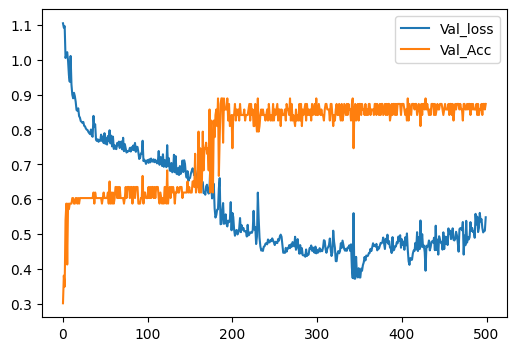

In [8]:
# visualisasi hasil loss dan acc dari proses pelatihan model
plt.figure(figsize=(6,4))
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Val_loss', 'Val_Acc'])
plt.show()

In [9]:
# model.save('model_saved')

In [10]:
model2 = load_model('model_saved')

In [11]:
# proses testing atau validasi dari model yang dsudah dilatih
predicted = model.predict(X_val)

# mengubah hasil prediksi menjadi class berdasarkan probabilitas 
predicted_classes = np.argmax(predicted, axis=1)

# menghitung tingkat akurasi (%)
true = 0
for x in range(0, len(predicted_classes)):
    if(predicted_classes[x] == val.filter(['Class']).values[x]):
        true = true + 1
accuracy = (true/len(val))*100
accuracy

2/2 [==============================] - 1s 2ms/step


87.3015873015873

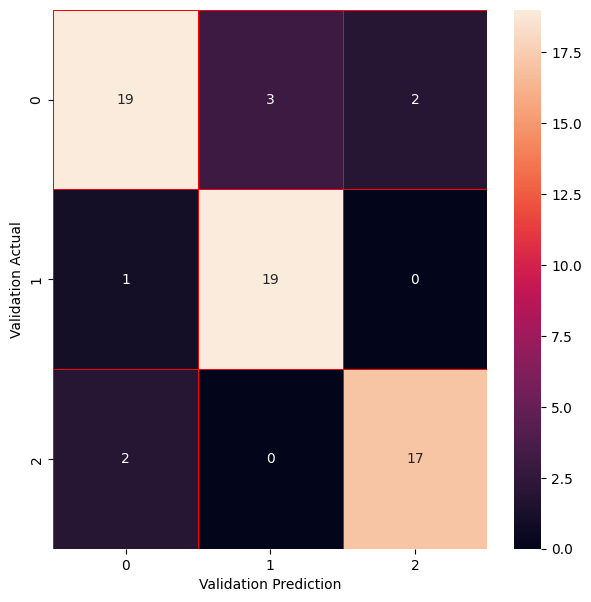

In [12]:
# membuat confussion matrix
val_true = np.array([x[0] for x in val.filter(["Class"]).values])
cm = confusion_matrix(val_true, predicted_classes)
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", ax=ax)
plt.xlabel("Validation Prediction")
plt.ylabel("Validation Actual")
plt.show()